# Классификация знаков Дорожного Движения

In [47]:
# !pip install natsort

In [48]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from skimage import transform

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')


import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import cv2
import os

from imutils import paths
import os
import pathlib
import LRFinder
from natsort import natsorted

Tensorflow version 2.10.0
GPU is ON


In [49]:
data = []
labels = []
sumu =0
start = 0
input_size = (60,60)
path = "./New_Dataset/prescriptive_signs/"
num_classes = len(os.listdir(path))
for file_number in os.listdir(path):
    path2 = str(path+file_number)
    num = 0
    count=0
    for file_number_2 in os.listdir(path2):
        path3 = str(path2 + '/' + file_number_2)
        if count == 700: break
        count = count+1
        imagepath = (path3)
#         print(imagepath)
        image = cv2.imread(imagepath, 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image = transform.resize(image, input_size)
        data.append(image)

        label = file_number
        labels.append(label)
    num = num + count
    sumu = sumu+count
    print(label, num)
print('all',sumu)

100 497
101 209
102 605
103 245
104 173
105 533
106 173
107 317
108 425
109 317
33 682
34 413
35 700
36 383
37 203
38 700
39 293
40 353
98 173
99 209
all 7603


In [50]:
df = pd.DataFrame({'labels': labels})
print(df.nunique())
print(df['labels'].value_counts())

labels    20
dtype: int64
38     700
35     700
33     682
102    605
105    533
100    497
108    425
34     413
36     383
40     353
107    317
109    317
39     293
103    245
101    209
99     209
37     203
106    173
104    173
98     173
Name: labels, dtype: int64


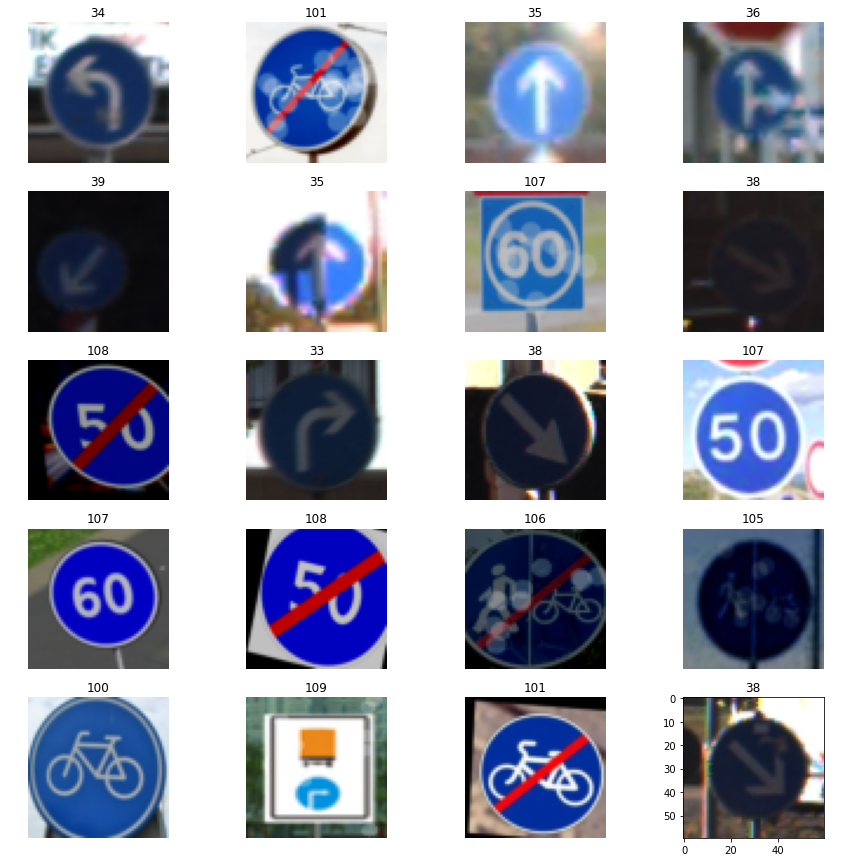

In [51]:
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    z = random.randint(1,len(labels))
    plt.axis('off') 
    fig.add_subplot(rows, columns, i)
    plt.title(labels[z])
    plt.imshow(data[z])
plt.show()

In [52]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 42, test_size = 0.3, stratify = labels)

from keras.utils import to_categorical
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [53]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D,UpSampling2D,ZeroPadding2D, Dense, Flatten, Dropout, BatchNormalization , Input, ReLU
from keras import initializers
import math
import tensorflow_addons as tfa

from keras.optimizers import SGD, Adam

opt = SGD(learning_rate=0.008)
# opt = Adam(learning_rate=0.0001)
# opt = SGD()
initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)

model = Sequential()
model.add(Input(shape=np.array(X_train).shape[1:]))

# model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=32, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.05))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=64, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.1))

# model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=128, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.15))

# model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(filters=256, kernel_size=5, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.2))

model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))


model.add(Flatten()) # по кол-ву пикселей из 2д в 1д
model.add(Dense(128, activation='swish')) # кол-во нейронов в слое
model.add(Dense(64, activation='swish')) # кол-во нейронов в слое
model.add(Dense(32, activation='swish')) # кол-во нейронов в слое
model.add(Dense(num_classes, kernel_initializer=initializer, bias_initializer=initializer, activation='softmax'))  # кол-во нейронов на выходе, по кол-ву классов


model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 58, 58, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 29, 29, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 29, 29, 32)        0         
                                                                 
 zero_padding2d_5 (ZeroPaddi  (None, 31, 31, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 64)      

In [54]:
# lr_finder = LRFinder.LRFinder(model)
# lr_finder.find(np.array(X_train), np.array(y_train), start_lr=0.00001, end_lr=1, batch_size=10, epochs=20)
# lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [55]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=5, epochs=50, validation_data=(np.array(X_test), np.array(y_test)))

Epoch 1/50
1065/1065 [==============================] - 14s 12ms/step - loss: 2.5044 - f1_score: 0.1152 - val_loss: 1.9992 - val_f1_score: 0.1791
Epoch 2/50
1065/1065 [==============================] - 12s 11ms/step - loss: 1.5464 - f1_score: 0.3677 - val_loss: 0.9361 - val_f1_score: 0.5887
Epoch 3/50
1065/1065 [==============================] - 12s 12ms/step - loss: 0.9023 - f1_score: 0.6396 - val_loss: 0.4329 - val_f1_score: 0.7999
Epoch 4/50
1065/1065 [==============================] - 13s 12ms/step - loss: 0.5332 - f1_score: 0.8097 - val_loss: 0.1933 - val_f1_score: 0.9310
Epoch 5/50
1065/1065 [==============================] - 13s 12ms/step - loss: 0.3650 - f1_score: 0.8718 - val_loss: 0.1604 - val_f1_score: 0.9506
Epoch 6/50
1065/1065 [==============================] - 12s 12ms/step - loss: 0.2683 - f1_score: 0.9099 - val_loss: 0.1298 - val_f1_score: 0.9489
Epoch 7/50
1065/1065 [==============================] - 12s 12ms/step - loss: 0.2131 - f1_score: 0.9305 - val_loss: 0.1063 -

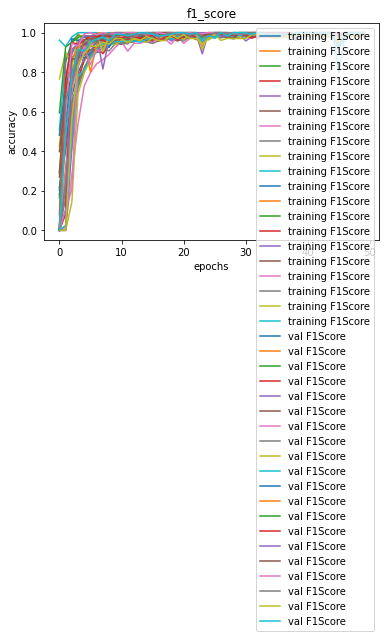

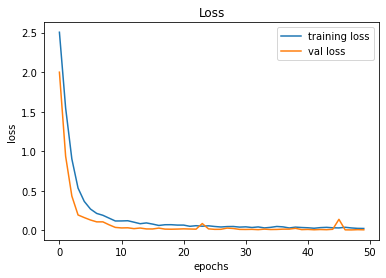

In [56]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['f1_score'], label='training F1Score')
plt.plot(history.history['val_f1_score'], label='val F1Score')
plt.title('f1_score')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [64]:
model.save('./saved_models/Trafic_Signs_CNN_presc_signs.h5')

In [58]:
presc_signs_classes = {'0':100,
'1':101,
'2':102,
'3':103,
'4':104,
'5':105,
'6':106,
'7':107,
'8':108,
'9':109,
'10':33,
'11':34,
'12':35,
'13':36,
'14':37,
'15':38,
'16':39,
'17':40,
'18':98,
'19':99,}

In [59]:
from sklearn.metrics import f1_score
df = pd.read_csv('./Data_images/Test_data.csv')
all_classes = []
predicted_classes = []
for c in range (33, 41):
    for i in range(60):
        
        all_classes.append(c)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
        classid = df.loc[df['ClassId'] == c].values[i][0]
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(presc_signs_classes[str(prediction[0])])
        
        if classid != presc_signs_classes[(str(prediction[0]))]:
             print(classid,presc_signs_classes[(str(prediction[0]))], prediction[0], image_path)


1/1 [==============================] - 0s 17ms/step
34 98 18 Test/11741.png
1/1 [==============================] - 0s 17ms/step
35 109 9 Test/11515.png
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
37 39 16 Test/07955.png
1/1 [==============================] - 0s 16ms/step
37 39 16 Test/08505.png
1/1 [==============================] - 0s 17ms/step
37 35 12 Test/04658.png
1/1 [==============================] - 0s 16ms/step
38 35 12 Test/03465.png
1/1 [==============================] - 0s 17ms/step
38 107 7 Test/02791.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
38 107 7 Test/08248.png
1/1 [==============================] - 0s 18ms/step
38 107 7 Test/08917.png
1/1 [==============================] - 0s 16ms/step
38 100 0 Test/06364.png
1/1 [==============================] - 0s 17ms/step
38 35 12 Test/05234.png
1/1 [==============================] - 0s 17ms/step
39 33 10 Test/01889.png
1/1 [==============================] - 0s 16ms/step
39 33 10 Test/08861.png
1/1 [==============================] - 0s 16ms/step
39 35 12 Test/09880.png
1/1 [==============================] - 0s 17ms/step
39 33 10 Test/10837.png
1/1 [==============================] - 0s 17ms/step
39 33 10 Test/02503.png
1/1 [==============================] - 0s 17ms/step
39 33 10 Test/00781.png
1/1 [==============================] - 0s 16ms/step
39 33 10 Test/02891.png
1/1 [==============================] - 0s 16ms/step
39 33 10 Test/12262.png
1/1 [==============================] - 0s 16ms/step
39 33 10 Test/08337.png
1/1 [=======

1/1 [==============================] - 0s 20ms/step
40 36 13 Test/01969.png
1/1 [==============================] - 0s 17ms/step
40 37 14 Test/03704.png
1/1 [==============================] - 0s 16ms/step


In [60]:
for c in range (98, 110):
    for i in range(60):
        
        all_classes.append(c)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
        classid = df.loc[df['ClassId'] == c].values[i][0]
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(presc_signs_classes[str(prediction[0])])
        
        if classid != presc_signs_classes[(str(prediction[0]))]:
             print(classid,presc_signs_classes[(str(prediction[0]))], prediction[0], image_path)


1/1 [==============================] - 0s 16ms/step
98 33 10 Test/98_1_11.png
1/1 [==============================] - 0s 16ms/step
98 35 12 Test/98_1_24.png
1/1 [==============================] - 0s 17ms/step
98 109 9 Test/98_1_19.png
1/1 [==============================] - 0s 17ms/step
98 105 5 Test/98_7_22.png
1/1 [==============================] - 0s 17ms/step
98 38 15 Test/98_4_29.png
1/1 [==============================] - 0s 17ms/step
98 100 0 Test/98_2_21.png
1/1 [==============================] - 0s 19ms/step
99 100 0 Test/99_3_35.png
1/1 [==============================] - 0s 16ms/step
99 100 0 Test/99_3_38.png
1/1 [==============================] - 0s 16ms/step
99 100 0 Test/99_2_5.png
1/1 [==============================] - 0s 17ms/step
99 100 0 Test/99_2_1.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
100 105 5 Test/100_5_13.png
1/1 [==============================] - 0s 16ms/step
101 109 9 Test/101_3_22.png
1/1 [==============================] - 0s 17ms/step
101 100 0 Test/101_3_27.png
1/1 [==============================] - 0s 17ms/step
101 100 0 Test/101_7_28.png
1/1 [==============================] - 0s 18ms/step
101 100 0 Test/101_3_30.png
1/1 [==============================] - 0s 24ms/step
101 100 0 Test/101_7_4.png
1/1 [==============================] - 0s 19ms/step
101 104 4 Test/101_4_27.png
1/1 [==============================] - 0s 17ms/step
101 108 8 Test/101_1_20.png
1/1 [==============================] - 0s 18ms/step
101 108 8 Test/101_7_25.png
1/1 [==============================] - 0s 20ms/step
102 33 10 Test/102_3_24.png
1/1 [==============================] - 0s 24ms/step
102 33 10 Test/102_1_19.png
1/1 [==============================] - 0s 17ms/step
102 109 9 Test/102_1_2.png
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 23ms/step
103 105 5 Test/103_1_18.png
1/1 [==============================] - 0s 17ms/step
103 105 5 Test/103_3_6.png
1/1 [==============================] - 0s 17ms/step
103 102 2 Test/103_1_20.png
1/1 [==============================] - 0s 18ms/step
103 105 5 Test/103_3_32.png
1/1 [==============================] - 0s 17ms/step
103 105 5 Test/103_3_9.png
1/1 [==============================] - 0s 22ms/step
104 109 9 Test/104_1_19.png
1/1 [==============================] - 0s 18ms/step
104 108 8 Test/104_2_20.png
1/1 [==============================] - 0s 18ms/step
104 109 9 Test/104_4_6.png
1/1 [==============================] - 0s 19ms/step
104 109 9 Test/104_4_17.png
1/1 [==============================] - 0s 20ms/step
104 108 8 Test/104_2_26.png
1/1 [==============================] - 0s 17ms/step
104 108 8 Test/104_2_30.png
1/1 [==============================] - 0s 17ms/step
104 108 8 Test/104_2_2.png
1/1 [==============================] - 0s 17

1/1 [==============================] - 0s 17ms/step
105 100 0 Test/105_1_13.png
1/1 [==============================] - 0s 17ms/step
105 33 10 Test/105_4_8.png
1/1 [==============================] - 0s 16ms/step
105 100 0 Test/105_1_33.png
1/1 [==============================] - 0s 18ms/step
105 33 10 Test/105_4_14.png
1/1 [==============================] - 0s 18ms/step
105 100 0 Test/105_1_11.png
1/1 [==============================] - 0s 17ms/step
106 108 8 Test/106_1_21.png
1/1 [==============================] - 0s 17ms/step
106 109 9 Test/106_3_17.png
1/1 [==============================] - 0s 18ms/step
106 105 5 Test/106_6_9.png
1/1 [==============================] - 0s 18ms/step
106 104 4 Test/106_2_25.png
1/1 [==============================] - 0s 17ms/step
106 102 2 Test/106_1_5.png
1/1 [==============================] - 0s 17ms/step
106 108 8 Test/106_2_34.png
1/1 [==============================] - 0s 17ms/step
106 108 8 Test/106_2_28.png
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 20ms/step
108 109 9 Test/108_5_27.png
1/1 [==============================] - 0s 17ms/step
108 109 9 Test/108_5_22.png
1/1 [==============================] - 0s 16ms/step
108 107 7 Test/108_5_14.png
1/1 [==============================] - 0s 17ms/step


In [61]:
print (f1_score(all_classes, predicted_classes, average='weighted'))

0.9212112760308823


Text(0.5, 0.98, 'Plot of confusion matrix')

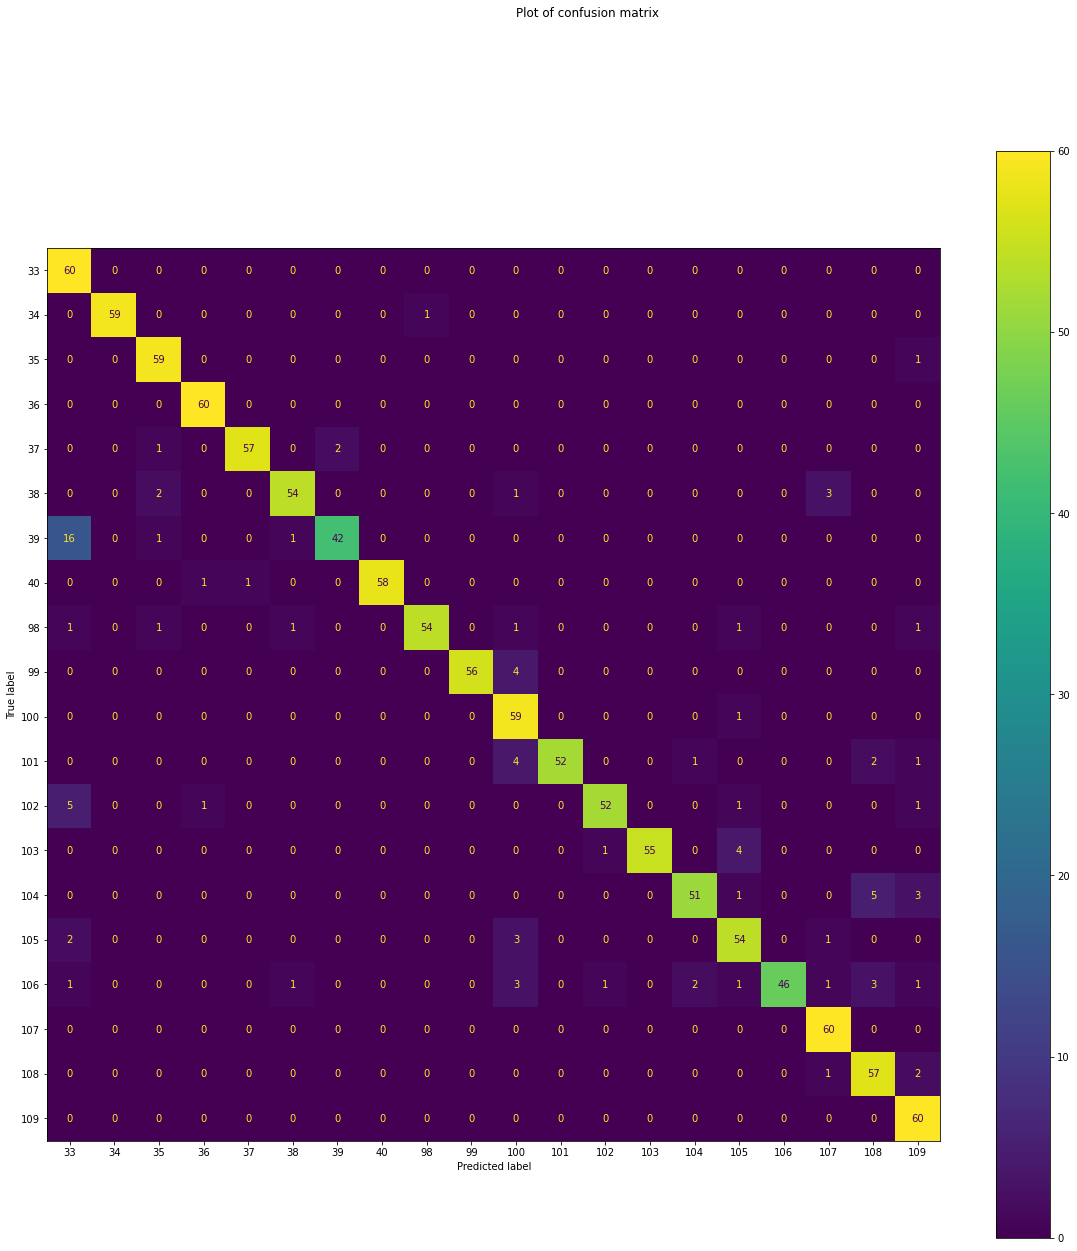

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display = ConfusionMatrixDisplay.from_predictions(all_classes, predicted_classes)
fig = display.figure_
fig.set_figwidth(20)
fig.set_figheight(20) 
fig.suptitle('Plot of confusion matrix')